In [1]:
# For notebook plotting
%matplotlib inline

# Standard packages
import os
import pickle
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# nltk for preprocessing of text data
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# sklearn for preprocessing and machine learning models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# XGBoost for Machine Learning (Gradient Boosting Machine (GBM))
import xgboost as xgb

# Keras for neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Random seeds for consistent results
from tensorflow import set_random_seed
seed = 1234
np.random.seed(seed)
set_random_seed(seed)

# Directory
KAGGLE_DIR = '../input/'

# List files and file sizes
print('\n# Files and file sizes')
for file in os.listdir(KAGGLE_DIR):
    print('{}| {} MB'.format(file.ljust(30), 
                             str(round(os.path.getsize(KAGGLE_DIR + file) / 1000000, 2))))

Using TensorFlow backend.



# Files and file sizes
database.sqlite               | 5.04 MB
Tweets.csv                    | 3.42 MB


## Data Exploration

For this section we are mostly interested in feature selection and the distribution of the target variable (airline_sentiment). If the target variable distribution is realistic and plausible we will move on the text preprocessing.

In [2]:
# Read in dataset
raw_df = pd.read_csv(f'{KAGGLE_DIR}Tweets.csv') 
print('Raw Dataframe:')
raw_df.head(1)

Raw Dataframe:


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)


In [3]:
# Select features
df = raw_df[['tweet_id', 'text', 'airline_sentiment']]
print('Feature selected DataFrame:')
df.head(2)

Feature selected DataFrame:


,tweet_id,text,airline_sentiment
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive


Note that the dataset is biased toward negative tweets. This is fine as long as the data we are trying to model is also biased towards negative. We are going to assume here that airline tweets outside this dataset also is for ± 60% negative.

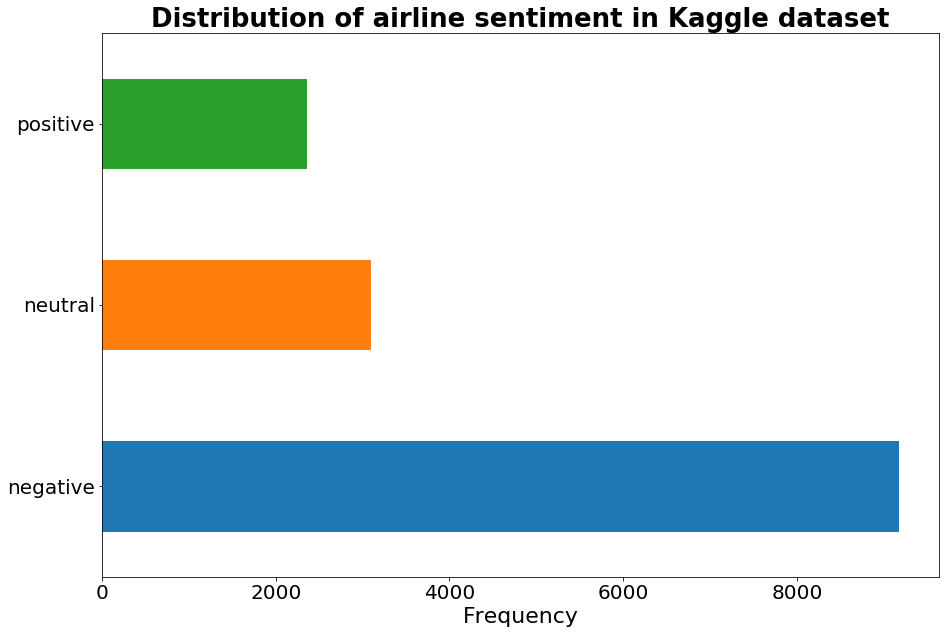

In [4]:
# Plot sentiment distribution
df['airline_sentiment'].value_counts().plot(kind = 'barh',
                                            figsize = (15,10));
plt.title('Distribution of airline sentiment in Kaggle dataset', 
          fontsize = 26, weight = 'bold')
plt.xlabel('Frequency', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

## Preprocessing

We created a preprocessor class to perform all steps that need to be performed before the text data can be vectorized. These preprocessing steps include:
1. [Tokenization](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization)
2. Removing [stop words](https://en.wikipedia.org/wiki/Stop_words)
3. [Stemming](https://en.wikipedia.org/wiki/Stemming)
4. Transform the tokens back to one string

In [5]:
class PreProcessor:
    '''
    Easily performs all the standard preprocessing steps
    like removing stopwords, stemming, etc.
    Only input that you need to provide is the dataframe and column name for the tweets
    '''
    def __init__(self, df, column_name):
        self.data = df
        self.conversations = list(self.data[column_name])
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer("english")
        self.preprocessed = []
        
    def tokenize(self, sentence):
        '''
        Splits up words and makes a list of all words in the tweet
        '''
        tokenized_sentence = word_tokenize(sentence)
        return tokenized_sentence
            
    def remove_stopwords(self, sentence):
        '''Removes stopwords like 'a', 'the', 'and', etc.'''
        filtered_sentence = []
        for w in sentence:
            if w not in self.stopwords and len(w) > 1 and w[:2] != '//' and w != 'https': 
                filtered_sentence.append(w)
        return filtered_sentence
    
    def stem(self, sentence):
        '''
        Stems certain words to their root form.
        For example, words like 'computer', 'computation'
        all get truncated to 'comput'
        '''
        return [self.stemmer.stem(word) for word in sentence]
    
    def join_to_string(self, sentence):
        '''
        Joins the tokenized words to one string.
        '''
        return ' '.join(sentence)
    
    def full_preprocess(self, n_rows=None):
        '''
        Preprocess a selected number of rows and
        connects them back to strings
        '''
        # If nothing is given do it for the whole dataset
        if n_rows == None:
            n_rows = len(self.data)
            
        # Perform preprocessing
        for i in range(n_rows):
            tweet = self.conversations[i]
            tokenized = self.tokenize(tweet)
            cleaned = self.remove_stopwords(tokenized)
            stemmed = self.stem(cleaned)
            joined = self.join_to_string(stemmed)
            self.preprocessed.append(joined)
        return self.preprocessed

In [6]:
# Preprocess text and put it in a new column
preprocessor = PreProcessor(df, 'text')
df['cleaned_text'] = preprocessor.full_preprocess()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Split data into train, validation and test sets

We split the data into a training set, validation set and test set. This is crucial for training and evaluation of good machine learning models.

The data will be shuffled and we take 1000 tweets for our test set. The remaining data will be split 80/20. This means that 80% will be used for training and 20% for validation set. During the model training phase our goal is to maximize the accuracy on the validation set. The test set is to check that our model truly generalizes to data it has never seen before.

In [7]:
# Shuffling so we can get random tweets for the test set
df = shuffle(df, random_state=seed)
# Keep 1000 samples of the data as test set
test_set = df[:1000]

In [8]:
# Get training and validation data
X_train, X_val, y_train, y_val = train_test_split(df['cleaned_text'][1000:], 
                                                  df['airline_sentiment'][1000:], 
                                                  test_size=0.2, 
                                                  random_state=seed)

# Get sentiment labels for test set
y_test = test_set['airline_sentiment']

## Data vectorization

Many machine learning models can only be trained on numerical input in the form of vectors or matrices. To prepare our tweets for the machine learning models we create a [term frequency-inverse document frequency (tf-idf) vectorization](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). The result of this vectorization is a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix) which contains a convenient representation of our tweets.

The machine learning will learn which word frequency is important to predict a correct sentiment. 

In [9]:
# Create matrix based on word frequency in tweets
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(test_set['cleaned_text'])

In [10]:
# Print the size of our data
print(f'Training size: {X_train.shape[0]} tweets\n\
Validation size: {X_val.shape[0]} tweets\n\
Test size: {X_test.shape[0]} tweets\n\
Amount of words (columns): {X_train.shape[1]} words')

Training size: 10912 tweets
Validation size: 2728 tweets
Test size: 1000 tweets
Amount of words (columns): 9672 words


## ML Models

### Multinomial Naive Bayes

Multinomial Naive Bayes is the go-to method for text mining and is great to set a benchmark for sentiment analysis. It is easy to implement with [sklearn's "MultinomialNB" class](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).

In [11]:
# Multinomial Naive Bayes
multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [12]:
# Check results
train_pred = multi_nb.predict(X_train)
val_pred = multi_nb.predict(X_val)
print(f'Accuracy on training set (MultinomialNB): {round(accuracy_score(y_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (MultinomialNB): {round(accuracy_score(y_val,val_pred)*100, 4)}%')

Accuracy on training set (MultinomialNB): 72.6998%
Accuracy on validation set (MultinomialNB): 69.1349%


### Sklearn's Gradient Boosting Machine (GBM)

The [Gradient Boosting Machine (GBM)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) is a powerful machine learning technique. The model basically trains decision trees models. It keeps training additive models on the residuals of the previous model. In this way we can get much better results than with a single decision tree. A GBM is however the most powerful if there is also plenty of labeled data. 

In [13]:
# sklearn's Gradient Boosting Classifier (GBM)
gbm = GradientBoostingClassifier(n_estimators=200, 
                                 max_depth=6, 
                                 random_state=seed)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=1234,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [14]:
# Check results
train_pred = gbm.predict(X_train)
val_pred = gbm.predict(X_val)
print(f'Accuracy on training set (GBM): {round(accuracy_score(y_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (GBM): {round(accuracy_score(y_val,val_pred)*100, 4)}%')

Accuracy on training set (GBM): 87.5367%
Accuracy on validation set (GBM): 76.4296%


### XGBoost (GBM)

[XGBoost](https://xgboost.readthedocs.io) is a Python package which provides an efficient implementation of a GBM. It often allows for more elaborate optimization than sklearn's GBM. In my experience, XGBoost often performs slightly better than sklearn's GBM.

In [15]:
# Hyperparameters that you can tweak
# There are a lot more tweakable hyperparameters that you can find at 
# https://xgboost.readthedocs.io/en/latest/parameter.html
xgb_params = {'objective' : 'multi:softmax',
              'eval_metric' : 'mlogloss',
              'eta' : 0.1,
              'max_depth' : 6,
              'num_class' : 3,
              'lambda' : 0.8,
              'estimators' : 200,
              'seed' : seed
              
}

# Transform categories into numbers
# negative = 0, neutral = 1 and positive = 2
target_train = y_train.astype('category').cat.codes
target_val = y_val.astype('category').cat.codes

# Transform data into a matrix so that we can use XGBoost
d_train = xgb.DMatrix(X_train, label = target_train)
d_val = xgb.DMatrix(X_val, label = target_val)

# Fit XGBoost
watchlist = [(d_train, 'train'), (d_val, 'validation')]
bst = xgb.train(xgb_params, 
                d_train, 
                400,  
                watchlist,
                early_stopping_rounds = 50, 
                verbose_eval = 0)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [16]:
# Check results for XGBoost
train_pred = bst.predict(d_train)
val_pred = bst.predict(d_val)
print(f'Accuracy on training set (XGBoost): {round(accuracy_score(target_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (XGBoost): {round(accuracy_score(target_val, val_pred)*100, 4)}%')

Accuracy on training set (XGBoost): 89.5803%
Accuracy on validation set (XGBoost): 77.3827%


## Simple neural network

Over the past years neural networks have given us extraordinary results on natural language processing (NLP) tasks with complex implementations. In this implementation however we will go back to basics and created a simple fully-connected neural networks with 20 neurons. The reason for this is that we have limited data and a small neural network model is already very prone to overfitting.

In [17]:
# Generator so we can easily feed batches of data to the neural network
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0]/batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

The neural network requires us to create a [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) of our target variable (airline_sentiment). This means that we encode our classes in the following way:
* negative = [1,0,0]
* neutral = [0,1,0]
* positive = [0,0,1]

In [18]:
# Onehot encoding of target variable
# Negative = [1,0,0], Neutral = [0,1,0], Positive = [0,0,1]

# Initialize sklearn's one-hot encoder class
onehot_encoder = OneHotEncoder(sparse=False)

# One hot encoding for training set
integer_encoded_train = np.array(y_train).reshape(len(y_train), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)

# One hot encoding for validation set
integer_encoded_val = np.array(y_val).reshape(len(y_val), 1)
onehot_encoded_val = onehot_encoder.fit_transform(integer_encoded_val)

Some interesting things to note about this network is the initializer and the activation functions.
We use [He Initialization](https://papers.nips.cc/paper/7338-how-to-start-training-the-effect-of-initialization-and-architecture.pdf) both to stabilize and to speed up training. He Initialization is designed so that it is more efficient than random initialization or worse, initializing to zeros. 

The [ELU activation function](https://arxiv.org/pdf/1511.07289.pdf) is in most cases more efficient and increases performance relative to other activation like LeakyReLU and ReLU ([Source](https://arxiv.org/pdf/1511.07289.pdf)). It is currently a mystery to me why people still use regular ReLU activations in their neural network models. If you know, please let me know in the comments!

In [19]:
# Neural network architecture
initializer = keras.initializers.he_normal(seed=seed)
activation = keras.activations.elu
optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)

# Build model architecture
model = Sequential()
model.add(Dense(20, activation=activation, kernel_initializer=initializer, input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax', kernel_initializer=initializer))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Hyperparameters
epochs = 50
batch_size = 32

# Fit the model using the batch_generator
hist = model.fit_generator(generator=batch_generator(X_train, onehot_encoded_train, batch_size=batch_size, shuffle=True),
                           epochs=epochs, validation_data=(X_val, onehot_encoded_val),
                           steps_per_epoch=X_train.shape[0]/batch_size, callbacks=[es])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
341/341 [==============================] - 2s 7ms/step - loss: 0.5784 - acc: 0.6979 - val_loss: 0.5197 - val_acc: 0.8071
Epoch 2/50
341/341 [==============================] - 2s 6ms/step - loss: 0.5007 - acc: 0.7785 - val_loss: 0.4724 - val_acc: 0.7826
Epoch 3/50
341/341 [==============================] - 2s 6ms/step - loss: 0.4637 - acc: 0.7897 - val_loss: 0.4431 - val_acc: 0.7996
Epoch 4/50
341/341 [==============================] - 2s 6ms/step - loss: 0.4307 - acc: 0.8089 - val_loss: 0.4175 - val_acc: 0.8115
Epoch 5/50
341/341 [==============================] - 2s 6ms/step - loss: 0.4003 - acc: 0.8229 - val_loss: 0.3962 - val_acc: 0.8239
Epoch 6/50
341/341 [==============================] - 2s 6ms/step - loss: 0.3748 - acc: 0.8346 - val_loss

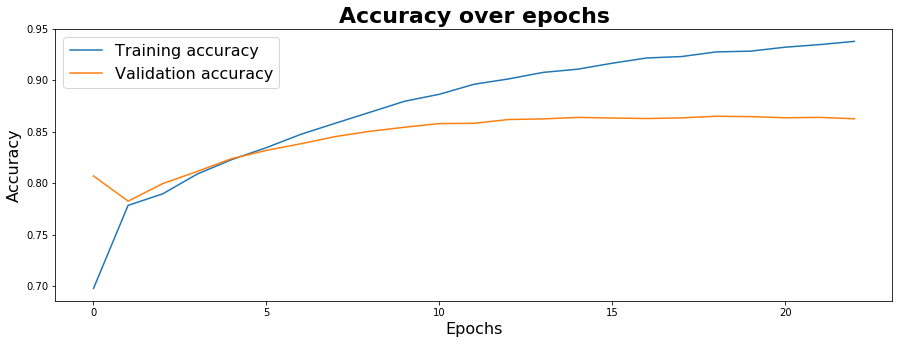

In [20]:
# Visualize Accuracy
acc = hist.history['acc']
val_acc = hist.history['val_acc']

# Get the amount of epochs for visualization
stopped_epoch = es.stopped_epoch
n_epochs = range(stopped_epoch+1)

# Plot training and validation accuracy
plt.figure(figsize=(15,5))
plt.plot(n_epochs, acc)
plt.plot(n_epochs, val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

In [21]:
# Check results of neural network model
train_pred = [np.argmax(pred) for pred in model.predict(X_train)]
val_pred = [np.argmax(pred) for pred in model.predict(X_val)]
print(f'Accuracy on training set (Small NN): {round(accuracy_score(target_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (Small NN): {round(accuracy_score(target_val, val_pred)*100, 4)}%')

Accuracy on training set (Small NN): 91.8897%
Accuracy on validation set (Small NN): 78.7757%


## Rule based models

Rule-based models can be very powerful for sentiment analysis tasks. Since this is a notebook about machine learning models I will not go deeply into rule-based models. It is however interesting to set a benchmark using a simple rule. Since our data is biased toward negative tweets, what is the accuracy if we always predict negative sentiment? 

### Always predict negative

In [22]:
# Predict negative for the whole dataset
negative_pred_train = ['negative' for _ in range(len(y_train))]
negative_pred_val = ['negative' for _ in range(len(y_val))]

print(f'Accuracy on training set (Always Predict Negative): {round(accuracy_score(y_train, negative_pred_train)*100, 4)}%')
print(f'Accuracy on validation set (Always Predict Negative): {round(accuracy_score(y_val, negative_pred_val)*100, 4)}%')

Accuracy on training set (Always Predict Negative): 62.445%
Accuracy on validation set (Always Predict Negative): 63.5264%


## Model comparison with test set

After tweaking the models for a high validation accuracy here we can see how the models actually perform on new data.

In [23]:
# Predict Always Negative
negative_test_pred = ['negative' for _ in range(len(y_test))]

# Multinomial Naive Bayes
multinb_test_pred = multi_nb.predict(X_test)

# Gradient Boosting Classifier
gbm_test_pred = gbm.predict(X_test)

# XGBoost
# Transform test data for XGBoost
target_test = y_test.astype('category').cat.codes
d_test = xgb.DMatrix(X_test, label = target_test)
xgboost_test_pred = bst.predict(d_test)

# Neural Network predictions
nn_test_pred = [np.argmax(pred) for pred in model.predict(X_test)]

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [24]:
# Get accuracies
print(f'Accuracy for Always Predict Negative: {round(accuracy_score(y_test, negative_test_pred)*100, 4)}%')
print(f'Accuracy for Multinomial Naive Bayes: {round(accuracy_score(y_test, multinb_test_pred)*100, 4)}%')
print(f'Accuracy for Gradient Boosting Classifier: {round(accuracy_score(y_test, gbm_test_pred)*100, 4)}%')
print(f'Accuracy for XGBoost: {round(accuracy_score(target_test, xgboost_test_pred)*100, 4)}%')
print(f'Accuracy for Neural Network: {round(accuracy_score(target_test, nn_test_pred)*100, 4)}%')

Accuracy for Always Predict Negative: 63.1%
Accuracy for Multinomial Naive Bayes: 67.8%
Accuracy for Gradient Boosting Classifier: 78.0%
Accuracy for XGBoost: 78.2%
Accuracy for Neural Network: 79.7%


## Save models

It seems like both the XGBoost and Neural Network models are the best to keep around. We therefore save the XGBoost model as a '.dat' file and the neural network weights in the '.h5' format.

In [25]:
# Save XGBoost model
pickle.dump(bst, open('xgboost_sentiment_model.dat', 'wb'))

# Save Neural Network model
model.save('nn_sentiment_model.h5')

## Make predictions

We will put our predictions from the XGBoost and Neural Network models in a DataFrame and make a quick comparison between them. This allows us to analyze tweets where the models do not agree on the prediction. For example, one model can predict negative sentiment while the other model predicts positive sentiment. If this occurs than a human can step in and check what is going wrong.

In [26]:
# Create dataframe with predictions for XGBoost and Neural Network
pred_df = pd.DataFrame({'tweet_id': test_set['tweet_id'],
                        'text' : test_set['text'],
                       'xgboost_pred' : xgboost_test_pred.astype(int),
                       'nn_pred' : nn_test_pred,})

# Change predictions back to string values
pred_df['xgboost_pred'] = pred_df['xgboost_pred'].map({0: 'Negative', 1: 'Neutral', 2 : 'Positive'})
pred_df['nn_pred'] = pred_df['nn_pred'].map({0: 'Negative', 1: 'Neutral', 2 : 'Positive'})

In [27]:
# Check if two models are in agreement
pred_df['pred_agreement'] = (pred_df['xgboost_pred'] == pred_df['nn_pred'])
print(f"The models agree with each other {round(pred_df['pred_agreement'].value_counts()[1]/len(pred_df)*100, 4)}% of the time.")

The models agree with each other 85.7% of the time.


## Save predictions to csv

We save the predictions on our test set for further analysis and reporting.

In [28]:
# Save to csv
pred_df.to_csv('sentiments.csv', index=False)

In [29]:
# Final test
df_test = pd.read_csv('sentiments.csv'); df_test.head(2)

,tweet_id,text,xgboost_pred,nn_pred,pred_agreement
0,568486436355346432,@USAirways we bought our tickets months ago. H...,Negative,Negative,True
1,568129652625158147,@united why is my flight from mke to ord getti...,Negative,Negative,True


**That's all! If you like this Kaggle kernel, feel free to give an upvote and leave a comment!**